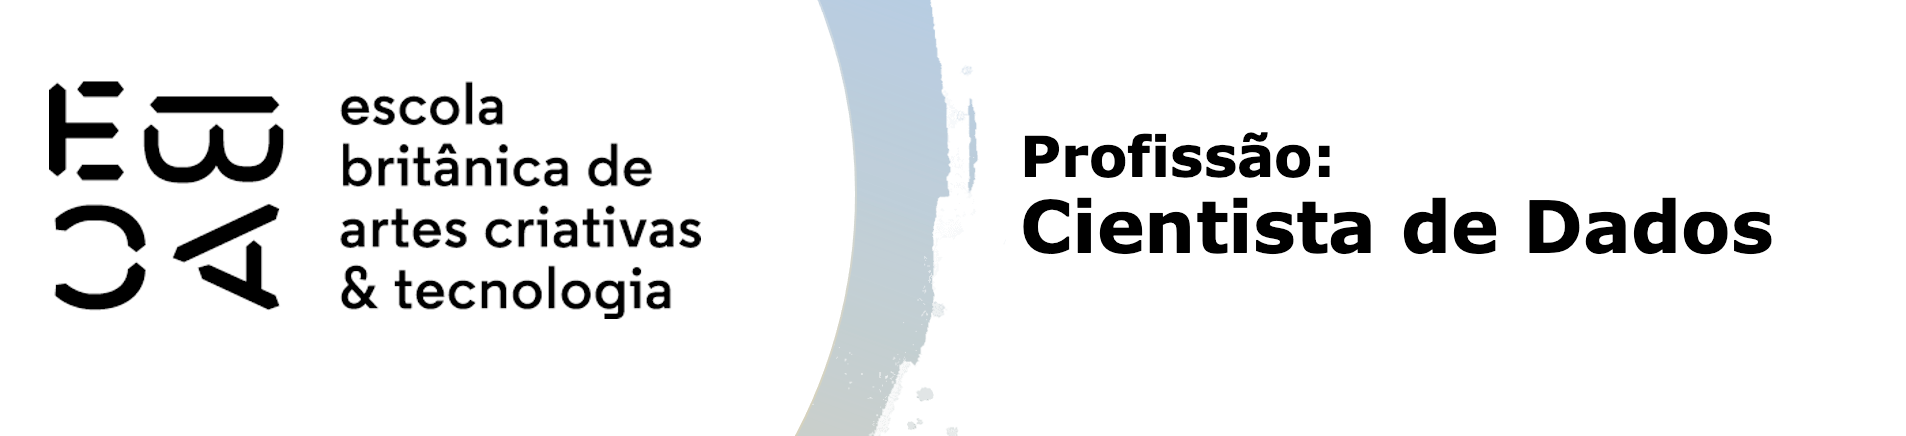

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from scipy.stats import ks_2samp

In [220]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [222]:
# Um tutor me pediu para deixar cada passo do código separado e com descrições para facilitar o entendimento.
# Por isso, estou deixando vários avisos.

# Aqui vamos definir a coluna 'data_ref' como tipo datetime.
df['data_ref'] = pd.to_datetime(df['data_ref'])

In [223]:
# Aqui vamos ordenar o DataFrame por data de forma decrescente.
df = df.sort_values('data_ref', ascending=False)

In [224]:
# Aqui vamos obter a data do terceiro mês mais recente.
ultimo_mes = df['data_ref'].unique()[2]

In [225]:
# Aqui estamos separando as safras de validação out of time.
tres_meses = df[df['data_ref'] >= ultimo_mes]

In [226]:
# Aqui vamos verificar o tamanho do DataFrame de validação out of time. Sabemos que o DataFrame completo tem 750000. 
print("Tamanho da amostra out of time:", len(tres_meses))

Tamanho da amostra out of time: 150000


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [227]:
# Qual é o númerdo de linhas do Dataframe?
num_linhas = len(df)
print("Número de linhas:", num_linhas)

Número de linhas: 750000


In [228]:
# Qual é o número de linhas para cada mês em data_ref?
num_linhas_por_mes = df['data_ref'].value_counts().sort_index()
print("Número de linhas por mês em data_ref:")
print(num_linhas_por_mes)

Número de linhas por mês em data_ref:
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64


In [229]:
# Vamos selecionar apenas as colunas relevantes para a análise (excluindo 'data_ref' e 'index').
colunas_analise = [coluna for coluna in df.columns if coluna not in ['data_ref', 'index']]

In [230]:
# Vamos fazer a descritiva básica univariada de cada variável.
for coluna in colunas_analise:
    if df[coluna].dtype == 'object':
        # Descritiva básica para variáveis qualitativas.
        descricao = df[coluna].describe()
    else:
        # Descritiva básica para variáveis quantitativas.
        descricao = df[coluna].describe().drop('count')
    print(f"\n--- Variável: {coluna} ---")
    print(descricao)



--- Variável: sexo ---
count     750000
unique         2
top            F
freq      504580
Name: sexo, dtype: object

--- Variável: posse_de_veiculo ---
count     750000
unique         2
top            N
freq      457954
Name: posse_de_veiculo, dtype: object

--- Variável: posse_de_imovel ---
count     750000
unique         2
top            S
freq      503692
Name: posse_de_imovel, dtype: object

--- Variável: qtd_filhos ---
mean     0.433251
std      0.739379
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max     14.000000
Name: qtd_filhos, dtype: float64

--- Variável: tipo_renda ---
count          750000
unique              5
top       Assalariado
freq           385740
Name: tipo_renda, dtype: object

--- Variável: educacao ---
count     750000
unique         5
top        Médio
freq      506836
Name: educacao, dtype: object

--- Variável: estado_civil ---
count     750000
unique         5
top       Casado
freq      526472
Name: estado_civil, dtype: object



## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [231]:
# Variáveis para análise descritiva bivariada (vamos excluir 'data_ref' e 'index').
variaveis = df.columns[2:-1]

In [232]:
# Vamos fazer a análise descritiva bivariada utilizando um for.
for variavel in variaveis:
    descricao_bivariada = df.groupby('mau')[variavel].describe()
    print(f"\n--- Variável: {variavel} ---")
    print(descricao_bivariada)


--- Variável: sexo ---
        count unique top    freq
mau                             
False  691357      2   F  463950
True    58643      2   F   40630

--- Variável: posse_de_veiculo ---
        count unique top    freq
mau                             
False  691357      2   N  421872
True    58643      2   N   36082

--- Variável: posse_de_imovel ---
        count unique top    freq
mau                             
False  691357      2   S  466842
True    58643      2   S   36850

--- Variável: qtd_filhos ---
          count      mean       std  min  25%  50%  75%   max
mau                                                          
False  691357.0  0.431739  0.737456  0.0  0.0  0.0  1.0  14.0
True    58643.0  0.451068  0.761465  0.0  0.0  0.0  1.0  14.0

--- Variável: tipo_renda ---
        count unique          top    freq
mau                                      
False  691357      5  Assalariado  354527
True    58643      5  Assalariado   31213

--- Variável: educacao ---
     

In [233]:
# Separando as variáveis qualitativas para análise descritiva bivariada (via gráfico, para facilitar a visualização).
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 
                          'estado_civil', 'tipo_residencia']

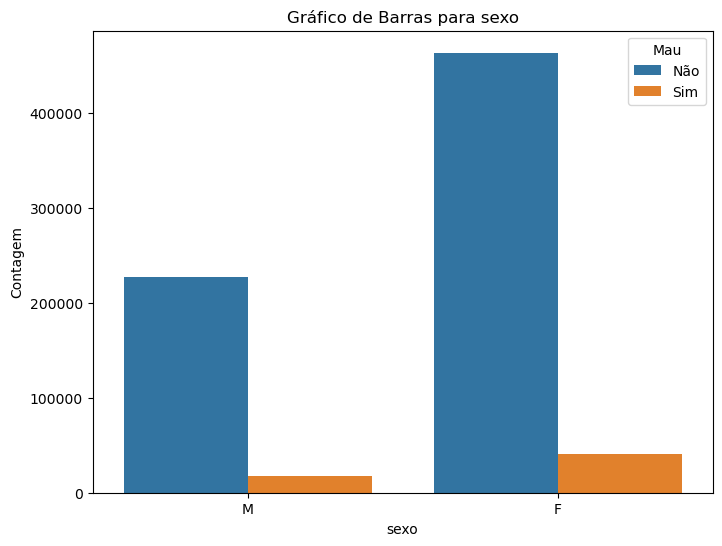

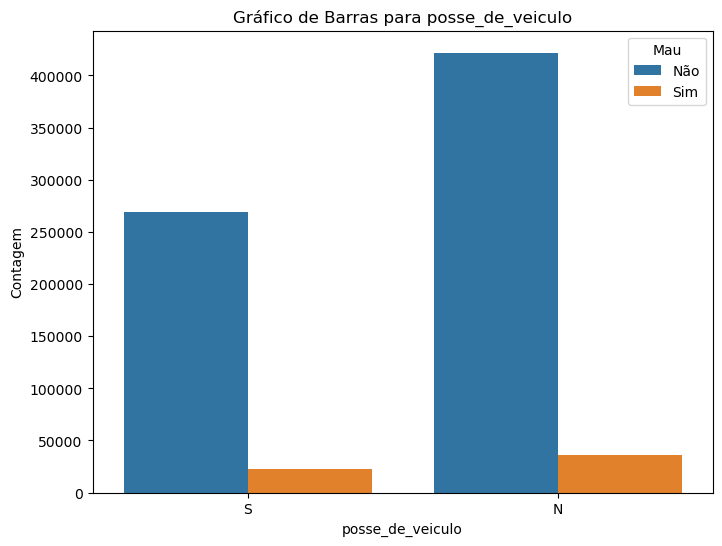

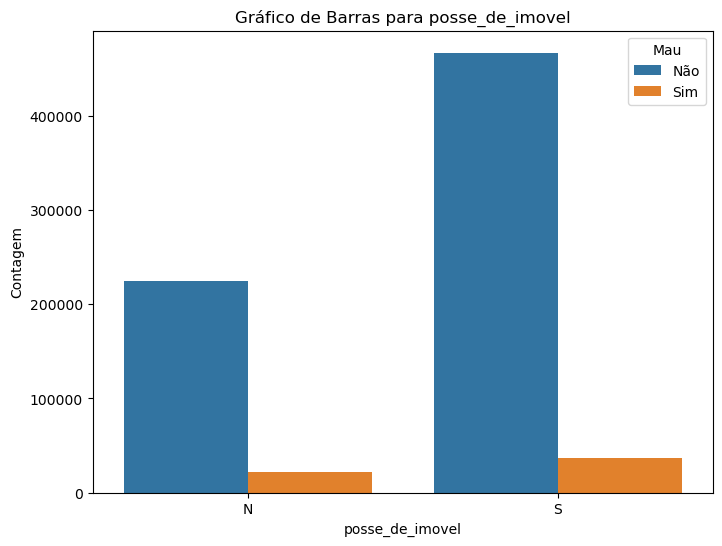

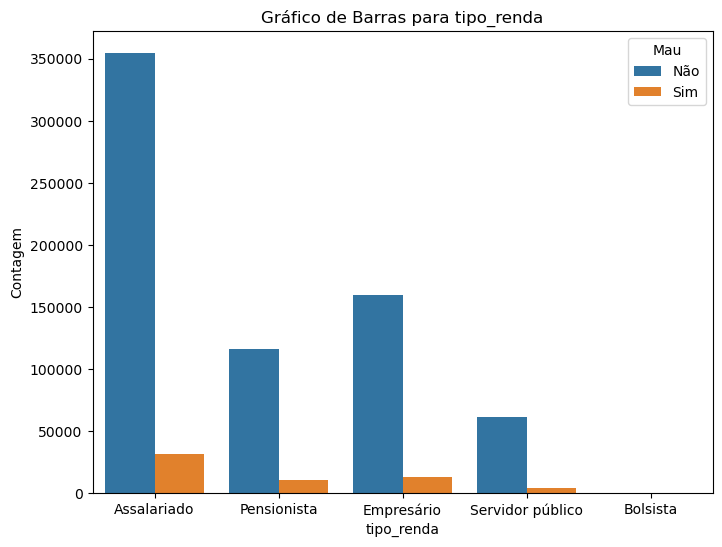

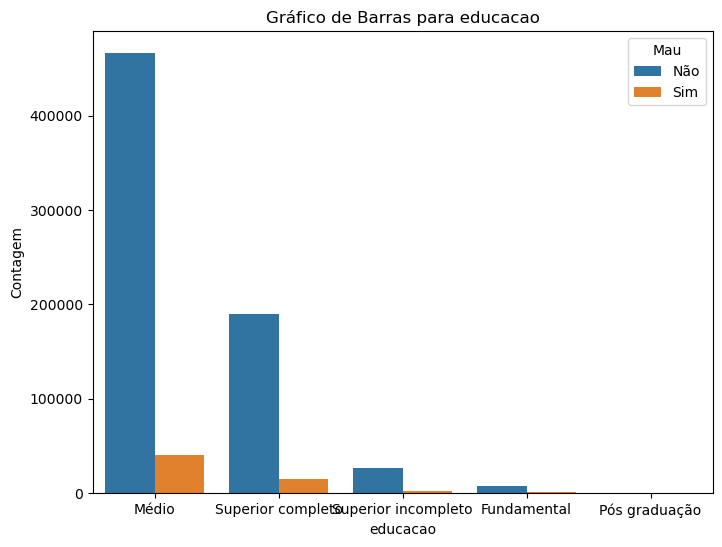

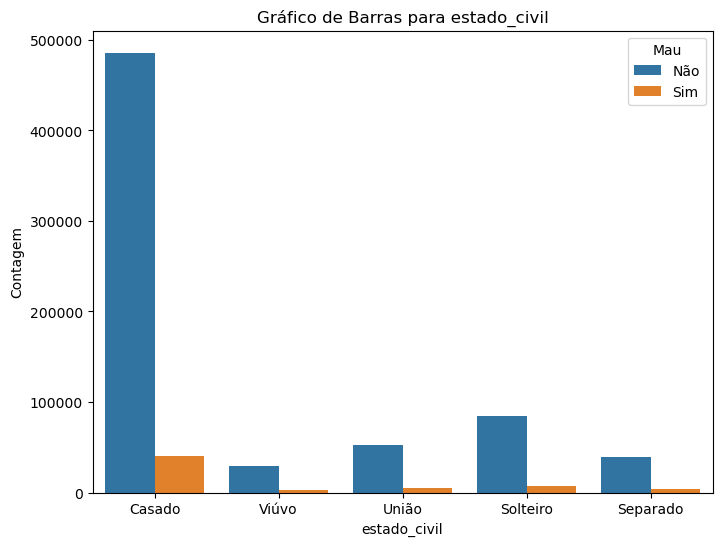

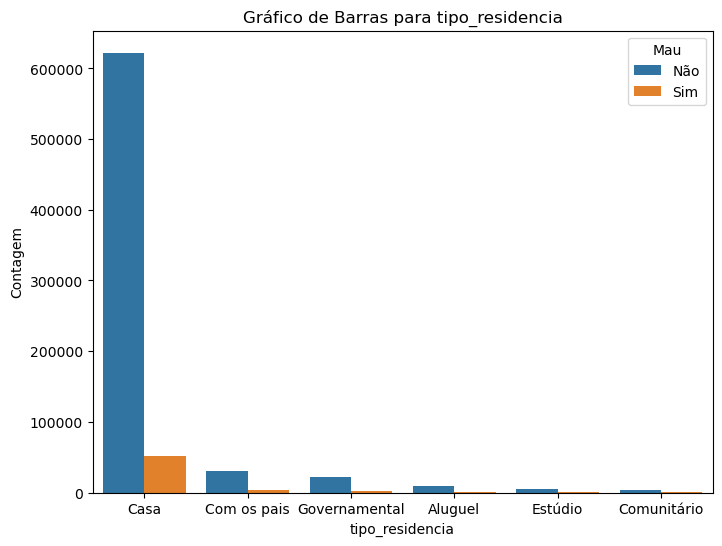

In [234]:
# Vamos usar um loop para criar gráficos de barras e facilitar a visualização dos dados.
for variavel in variaveis_qualitativas:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=variavel, hue='mau', data=df)
    plt.xlabel(variavel)
    plt.ylabel('Contagem')
    plt.title(f'Gráfico de Barras para {variavel}')
    plt.legend(title='Mau', labels=['Não', 'Sim'])
    plt.show()


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [235]:
# Analisando as variáveis, percebi que não é necessário tratar outliers.
# Vamos verificar valores ausentes.
missing_values = df.isnull().sum()

In [236]:
# Agora vamos exibir a contagem de valores ausentes por coluna.
print(missing_values)

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64


In [237]:
# Nesse momento precisamos decidir como tratar os missings. Eu preferi substituí-los pela média.
mean_value = df['tempo_emprego'].mean()
df['tempo_emprego'] = df['tempo_emprego'].fillna(mean_value)

In [238]:
# Vamos verificar se deu certo a substituição dos valores ausentes.
missing_values = df.isnull().sum()
print(missing_values)

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


<span style="color:blue">Ao analisar a descrição estatística univariada das variáveis, foi observado que apenas a variável "qtd_filhos" apresenta a presença de zeros estruturais. No entanto, é importante ressaltar que esses zeros têm um significado específico, indicando a ausência de filhos para determinados indivíduos. Portanto, não é necessário realizar nenhum procedimento de tratamento para esses "zeros estruturais", uma vez que eles representam uma informação válida e relevante dentro do contexto da variável.</span>

In [239]:
# Vamos remover as colunas 'data_ref' e 'index', pois, elas não irão ajudar a predizer a variável 'mau'.
df = df.drop(['data_ref', 'index'], axis=1)

In [240]:
# Agora precisamos converter variáveis categóricas em colunas binárias.
df_encoded = pd.get_dummies(df, drop_first=True)

In [241]:
# Vamos separar as variáveis preditoras (X) e a variável alvo mau (y).
X = df_encoded.drop('mau', axis=1)
y = df_encoded['mau']

In [242]:
# Nessa etapa vamos dividir o conjunto de dados em treinamento e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [243]:
# Criando o modelo de regressão logística.
model = LogisticRegression()

In [244]:
# Vamos treinar o modelo com os dados de treinamento.
model.fit(X_train, y_train)

LogisticRegression()

In [245]:
# Agora vamos fazer previsões com os dados de teste.
y_pred = model.predict(X_test)

In [246]:
# E por fim, vamos avaliar a precisão do modelo.
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)

Acurácia do modelo: 0.9226533333333333


In [247]:
# Vamos ajustar o modelo de regressão logística usando statsmodels.
modelo = sm.Logit(y_train, X_train)
resultado = modelo.fit()

Optimization terminated successfully.
         Current function value: 0.245518
         Iterations 10


In [248]:
# Agora vamos obter os coeficientes estimados.
coeficientes = resultado.params

In [249]:
# Vamos calcular os erro padrão dos coeficientes.
erros_padrao = resultado.bse

In [250]:
# Vamos calcular os testes de Wald e os p-valores associados.
wald_tests = coeficientes / erros_padrao
p_values = 2 * (1 - stats.norm.cdf(np.abs(wald_tests)))

In [251]:
# Agora iremos criar um dataframe com os coeficientes e os p-valores.
df_resultados = pd.DataFrame({'Variável': X_train.columns, 'Coeficiente': coeficientes, 'p-valor': p_values})

print(df_resultados)

                                                    Variável  Coeficiente  \
qtd_filhos                                        qtd_filhos     0.458546   
idade                                                  idade    -0.000884   
tempo_emprego                                  tempo_emprego    -0.026949   
qt_pessoas_residencia                  qt_pessoas_residencia    -0.461833   
renda                                                  renda    -0.000126   
sexo_M                                                sexo_M    -0.121994   
posse_de_veiculo_S                        posse_de_veiculo_S     0.020402   
posse_de_imovel_S                          posse_de_imovel_S    -0.093426   
tipo_renda_Bolsista                      tipo_renda_Bolsista    -0.470130   
tipo_renda_Empresário                  tipo_renda_Empresário    -0.055716   
tipo_renda_Pensionista                tipo_renda_Pensionista    -0.010207   
tipo_renda_Servidor público      tipo_renda_Servidor público    -0.023524   

In [252]:
# Vamos filtrar as variáveis significativas (p < 0.05) e as insignificantes (p >= 0.05).
variaveis_significativas = df_results[df_results['p-valor'] < 0.05]
variaveis_insignificantes = df_results[df_results['p-valor'] >= 0.05]

print("Variáveis significativas:")
print(variaveis_significativas)

print("Variáveis insignificantes:")
print(variaveis_insignificantes)


Variáveis significativas:
                                                  Variável  Coeficiente  \
qtd_filhos                                      qtd_filhos     0.458546   
tempo_emprego                                tempo_emprego    -0.026949   
qt_pessoas_residencia                qt_pessoas_residencia    -0.461833   
renda                                                renda    -0.000126   
sexo_M                                              sexo_M    -0.121994   
posse_de_imovel_S                        posse_de_imovel_S    -0.093426   
tipo_renda_Empresário                tipo_renda_Empresário    -0.055716   
educacao_Médio                              educacao_Médio    -0.138483   
educacao_Superior completo      educacao_Superior completo    -0.193840   
educacao_Superior incompleto  educacao_Superior incompleto    -0.182567   
estado_civil_Separado                estado_civil_Separado    -0.435225   
estado_civil_Solteiro                estado_civil_Solteiro    -0.469498   

## RESPOSTA:

<span style="color:blue">Com base nos 'p-value' obtidos, as seguintes variáveis são estatisticamente significativas para prever a inadimplência (variável 'mau'):</span>

- quantidade de filhos
- tempo de emprego
- quantidade de pessoas na residência
- renda
- sexo
- posse de imóvel
- tipo de renda empresarial
- nível de escolaridade médio
- nível de escolaridade superior completo
- nível de escolaridade superior incompleto
- estado civil separado
- estado civil solteiro
- estado civil viúvo
- tipo de residência casa
- tipo de residência com os pais
- tipo de residência comunitário

<span style="color:blue">Essas variáveis apresentaram uma relação estatisticamente significativa com a variável de resposta e, portanto, podem ser consideradas significantes para o modelo de previsão de inadimplência.</span>

<span style="color:blue">Com base nos 'p-value' obtidos, as seguintes variáveis não são estatisticamente significativas para prever a inadimplência (variável 'mau'):</span>

- idade
- posse de veículo
- tipo de renda bolsista
- tipo de renda pensionista
- tipo de renda servidor público
- nível de escolaridade pós-graduação
- tipo de residência estúdio
- tipo de residência governamental

<span style="color:blue">Essas variáveis não apresentaram uma relação estatisticamente significativa com a variável de resposta e, portanto, podem ser consideradas insignificantes para o modelo de previsão de inadimplência.</span>

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [254]:
# Agora vamos fazer previsões no conjunto de teste.
y_pred = result.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

In [255]:
# Aqui iremos calcular a acurácia.
acuracia = accuracy_score(y_test, y_pred_binary)

In [256]:
# Vamos Calcular o KS.
ks = ks_2samp(y_pred[y_test == 1], y_pred[y_test == 0]).statistic

In [257]:
# Para finalizar, iremos calcular o Gini.
gini = (2 * roc_auc_score(y_test, y_pred)) - 1

print("Acurácia:", acuracia)
print("KS:", ks)
print("Gini:", gini)

Acurácia: 0.9226533333333333
KS: 0.4183286360942801
Gini: 0.5587519637837555


## RESPOSTA:

- Acurácia: indicou previsões corretas em relação ao total de observações. No nosso caso, a acurácia foi de 92.27%. Isso significa que o modelo classificou corretamente cerca de 92.27% dos casos de inadimplência.

- KS: foi de 0.42, indicando que o modelo apresenta uma boa capacidade de discriminação entre clientes adimplentes e inadimplentes.

- Gini: o valor do Gini varia de -1 a 1, onde 1 indica uma classificação perfeita e 0 indica um desempenho aleatório. No nosso caso, o Gini foi de 0.56, o que indica um desempenho razoável do modelo na classificação das observações.

No geral, com base nessas métricas, podemos concluir que o modelo tem um desempenho promissor na previsão da inadimplência.